# Libraries

In [16]:
import tensorflow as tf
from matplotlib import pyplot as plt
from keras import models as m
from keras import layers as l
from keras import optimizers as o
from keras import regularizers as r
from tqdm import tqdm
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
import cv2

# CIFAR-10

After loading the CIFAR-10 datasets ({x_train, y_train} for the training of our NN and {x_test, y_test} for the evaluation of it) we transformed the color images into gray scale in order to reduce the computational cost. We also reshaped the arrays x_train and x_test to four dimensions so that they could work with the Keras API. In addition, we normalized the values of the pictures in the interval [-1, 1] in order to help our NN converge faster to the solution. Needless to say that, before normalizing our data we casted their values to float so as not to lose any information.

In [17]:
# Loading the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Gray scaling the images
x_train = np.array([cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) for image in x_train])
x_test = np.array([cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) for image in x_test])

# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1)

# Casting Float values so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
x_train = (x_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

# Discriminator

The Discriminator was based on the LeNet-5 architecture and consists of three convolutional layers followed by two fully connected layers with a softmax output of ten classes at the end. In all layers we used LeakyReLU as activation function because it has better gradient propagation than sigmoid and tanh and tackles the dying ReLU problem with its slope. We also used batch normalization and after all layers and L2 regularization in some of the convolutional layers in an attempt to normalize the activations of the various layers and reduce overfitting. In addition we used a dropout regularization after each set of layers to reduce overfitting even more. Finally, we used max-pooling after every two convolutions to reduce the computational cost, by reducing the number of parameters to learn.

In [18]:
discriminator = m.Sequential()

discriminator.add(l.Conv2D(32, kernel_size=3, kernel_initializer='he_uniform',
                  strides=1, padding='same', input_shape=(32, 32, 1), 
                  kernel_regularizer=r.l2(0.0002)))
discriminator.add(l.LeakyReLU(alpha=0.2))
discriminator.add(l.BatchNormalization())
discriminator.add(l.MaxPooling2D(pool_size=2, strides=2))
discriminator.add(l.Dropout(0.35))


discriminator.add(l.Conv2D(64, kernel_size=3, kernel_initializer='he_uniform',
                  strides=1, padding='same', kernel_regularizer=r.l2(0.0002)))
discriminator.add(l.LeakyReLU(alpha=0.2))
discriminator.add(l.BatchNormalization())
discriminator.add(l.MaxPooling2D(pool_size=2, strides=2))
discriminator.add(l.Dropout(0.35))


discriminator.add(l.Conv2D(128, kernel_size=3, kernel_initializer='he_uniform',
                  strides=1, padding='same', kernel_regularizer=r.l2(0.0002)))
discriminator.add(l.LeakyReLU(alpha=0.2))
discriminator.add(l.BatchNormalization())
discriminator.add(l.MaxPooling2D(pool_size=2, strides=2))
discriminator.add(l.Dropout(0.35))

discriminator.add(l.Flatten())

discriminator.add(l.Dense(128,kernel_initializer='he_uniform'))
discriminator.add(l.LeakyReLU(alpha=0.2))
discriminator.add(l.BatchNormalization())
discriminator.add(l.Dropout(0.35))

discriminator.add(l.Dense(64,kernel_initializer='he_uniform'))
discriminator.add(l.LeakyReLU(alpha=0.2))
discriminator.add(l.BatchNormalization())
discriminator.add(l.Dropout(0.35))

discriminator.add(l.Dense(10, activation='softmax'))

discriminator.summary()
# plot_model(discriminator, to_file='discriminator_plot.png',
#            show_shapes=True, show_layer_names=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16, 16, 64)       

# Compilation & Evaluation

For the compilation of the Discriminator we used as loss function the categorical crossentropy for we had the tags one hot encoded, as optimizer the Adam optimizer and as metrics the accuracy of the predicted images. As far as the training is concerned we had our neural network train for 26 epochs, while enabling the shuffling of the images in the training set.

In [19]:
# Onehot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Compilation
discriminator.compile(loss='categorical_crossentropy', 
                      optimizer=o.Adam(lr=0.0009, decay=1e-6),
                      metrics=['accuracy'])

# Evaluation
discriminator.fit(x=x_train, y=y_train, epochs=26, shuffle=True, 
                  validation_data=(x_test, y_test), batch_size=64)

Epoch 1/26
782/782 [==============================] - 6s 6ms/step - loss: 2.2075 - accuracy: 0.2939 - val_loss: 1.9815 - val_accuracy: 0.3537
Epoch 2/26
782/782 [==============================] - 5s 6ms/step - loss: 1.5348 - accuracy: 0.4856 - val_loss: 1.3287 - val_accuracy: 0.5634
Epoch 3/26
782/782 [==============================] - 5s 6ms/step - loss: 1.3473 - accuracy: 0.5603 - val_loss: 1.2508 - val_accuracy: 0.5977
Epoch 4/26
782/782 [==============================] - 5s 6ms/step - loss: 1.2515 - accuracy: 0.5902 - val_loss: 1.0996 - val_accuracy: 0.6483
Epoch 5/26
782/782 [==============================] - 5s 6ms/step - loss: 1.1753 - accuracy: 0.6196 - val_loss: 1.0520 - val_accuracy: 0.6595
Epoch 6/26
782/782 [==============================] - 5s 6ms/step - loss: 1.1195 - accuracy: 0.6395 - val_loss: 0.9659 - val_accuracy: 0.6919
Epoch 7/26
782/782 [==============================] - 5s 6ms/step - loss: 1.0756 - accuracy: 0.6547 - val_loss: 0.9608 - val_accuracy: 0.6908
Epoch 

# Generator

The Generator consists of one dense input layer followed by three transposed convolutional layers with a tanh output layer at the end. Again, as in the Discriminator, we used the LeakyReLU as activation function in all layers, except the output, because it has better gradient propagation than sigmoid and tanh and tackles the dying ReLU problem with its slope. We also used batch normalization after all layers to normalize their activations. The number of nodes in the input layer is a multiple of 16 (4x4), which then is multiplied by 2 from each of the three transposed convolutional filters and finally gets resized in a (32, 32, 1) image which is the generated image. The reason we used tanh as the activation function of the output layer is because it gave us the best results for this network.

In [20]:
# define the number of nodes in the Input layer
n_nodes = 256 * 4 * 4

generator = m.Sequential()

# foundation for 4x4 image
generator.add(l.Dense(n_nodes, input_dim=1))
generator.add(l.LeakyReLU(alpha=0.2))
generator.add(l.Reshape((4, 4, 256)))

# upsample to 8x8
generator.add(l.Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
generator.add(l.LeakyReLU(alpha=0.2))

# upsample to 16x16
generator.add(l.Conv2DTranspose(768, (4,4), strides=(2,2), padding='same'))
generator.add(l.LeakyReLU(alpha=0.2))

# upsample to 32x32
generator.add(l.Conv2DTranspose(1024, (4,4), strides=(2,2), padding='same'))
generator.add(l.LeakyReLU(alpha=0.2))

# output
generator.add(l.Dense(1, activation='tanh'))
generator.add(l.Reshape((32, 32, 1)))

generator.summary()
# plot_model(generator, to_file='generator_plot.png', show_shapes=True,
#            show_layer_names=True)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 4096)              8192      
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 512)         2097664   
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 768)       6292224   
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 16, 16, 768)      

# Compilation

For the compilation of the Generator we used as loss function the mean squared error because it is mostly used for regression and we want to generate copies of images, as optimizer the Adam optimizer and as metrics the root mean squared error of the generated images.

In [21]:
generator.compile(loss='mean_squared_error', 
                  optimizer=o.Adam(lr=0.0009, decay=1e-6),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Generative Adversarial Network

The generative adversarial network consists of the Generator as input and the Discriminator which was rendered not trainable as output.

In [22]:
discriminator.trainable = False

gan = m.Sequential()
gan.add(generator)
gan.add(discriminator)

gan.summary()
# plot_model(gan, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 32, 32, 1)         20983041  
_________________________________________________________________
sequential_4 (Sequential)    (None, 10)                365514    
Total params: 21,348,555
Trainable params: 20,983,041
Non-trainable params: 365,514
_________________________________________________________________


# Compilation

For the compilation of the GAN we used as loss function the categorical crossentropy, as optimizer the Adam optimizer and as metrics the accuracy of the predicted images because we use the Discriminator as output.

In [23]:
gan.compile(loss='categorical_crossentropy', 
            optimizer=o.Adam(lr=0.0009, decay=1e-6),
            metrics='accuracy')

# Training

The GAN used 1 image of our liking to construct adversary images of all other classes, with a training of 100 epochs for each class.

In [24]:
classes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
generated_images = []

images = x_train[30:31]
for image in images:
  for target in classes:
    if target != y_train[31][0]:
      target_class = np.zeros((1,10))
      target_class[0][target] = 1
      for _ in tqdm(range(100)):
        generator.train_on_batch([np.array([1])], image.reshape((1,32,32,1)))
        gan.train_on_batch([np.array([1])], target_class)
      generated_images.append(generator.predict([np.array([1])]))

100%|██████████| 100/100 [00:04<00:00, 24.57it/s]


# Results

Below we print the adversary images and also the class that the Discriminator predicts them to be.

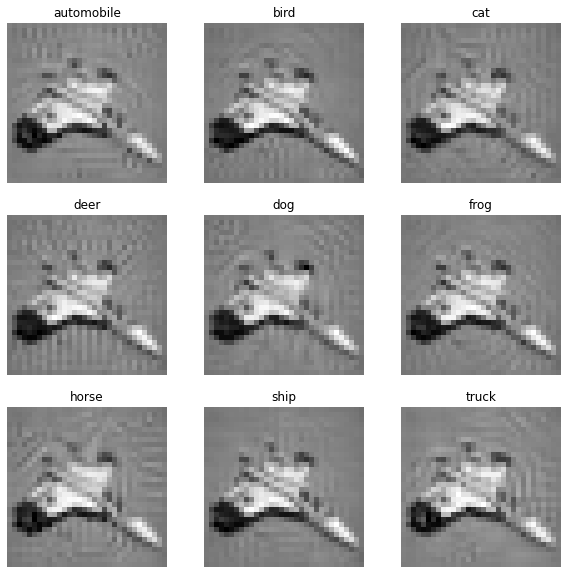

In [25]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(len(generated_images)):
  plt.subplot(len(images)*3, (len(classes) - 1)/3, i+1)
  plt.axis('off')
  plt.imshow(((generated_images[i]+1)/2).reshape((32,32)), cmap='gray')
  plt.title(labels[np.argmax(discriminator.predict(generated_images[i]))])
# save plot to file
filename = 'generated_images.png' 
plt.savefig(filename)
plt.show()


# Comments

From the above images we can see that the GAN could construct pretty good adversarial images for all classes. Although, the noise is perceptible to the human eye it is really difficult to match its pattern to one of the classes that the Discriminator does.

# Overcomming the problem

We believe that a way to defend against adversarial attacks is, firstly, by building a deep neural network, capable of discerning many different patterns. Secondly, by augmenting the data (e.g. rotating, width & height shifting, horizontal flipping and zooming the image) the neural network can achieve better generalization and thus have it's prediction accuracy increased, on new data. Finally, by introducing gaussian noise at the output of each set of layers of the neural network, we can make it develop an even greater generalization ability.

# Deeper Discriminator

The Deeper Discriminator model is based on the previous Discriminator architecture and consists of six convolutional layers, followed by three fully connected layers with a softmax output of ten classes at the end. In all layers, except the output, we used LeakyReLU as activation function because it has better gradient propagation than sigmoid and tanh and tackles the dying ReLU problem with its slope. We also used batch normalization and L2 regularization in an attempt to normalize the activations of the various layers and reduce overfitting. In addition, we used a dropout regularization after each set of layers to reduce overfitting even more. We also used a generalization technique which is adding Gaussian noise at the output after each set of layers. Finally, we used max-pooling after three of the convolutions to reduce the computational cost, by reducing the number of parameters to learn. 

In [26]:
deeper_discriminator = m.Sequential()

deeper_discriminator.add(l.Conv2D(32, kernel_size=3, kernel_initializer='he_uniform',
                  strides=1, padding='same', input_shape=(32, 32, 1), 
                  kernel_regularizer=r.l2(0.0005)))
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.GaussianNoise(0.4))

deeper_discriminator.add(l.Conv2D(32, kernel_size=3, kernel_initializer='he_uniform',
                  strides=1, padding='same'))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.MaxPooling2D(pool_size=2, strides=2))
deeper_discriminator.add(l.Dropout(0.3))
deeper_discriminator.add(l.GaussianNoise(0.4))


deeper_discriminator.add(l.Conv2D(64, kernel_size=3, kernel_initializer='he_uniform',
                  strides=1, padding='same', kernel_regularizer=r.l2(0.0005)))
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.GaussianNoise(0.4))

deeper_discriminator.add(l.Conv2D(64, kernel_size=3, kernel_initializer='he_uniform',
                  strides=1, padding='same'))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.MaxPooling2D(pool_size=2, strides=2))
deeper_discriminator.add(l.Dropout(0.3))
deeper_discriminator.add(l.GaussianNoise(0.4))


deeper_discriminator.add(l.Conv2D(128, kernel_size=3, kernel_initializer='he_uniform',
                  strides=1, padding='same', kernel_regularizer=r.l2(0.0005)))
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.GaussianNoise(0.4))

deeper_discriminator.add(l.Conv2D(128, kernel_size=3, kernel_initializer='he_uniform',
                  strides=1, padding='same'))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.MaxPooling2D(pool_size=2, strides=2))
deeper_discriminator.add(l.Dropout(0.3))
deeper_discriminator.add(l.GaussianNoise(0.4))

deeper_discriminator.add(l.Flatten())

deeper_discriminator.add(l.Dense(128,kernel_initializer='he_uniform'))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.Dropout(0.4))
deeper_discriminator.add(l.GaussianNoise(0.4))

deeper_discriminator.add(l.Dense(96,kernel_initializer='he_uniform'))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.Dropout(0.4))
deeper_discriminator.add(l.GaussianNoise(0.45))

deeper_discriminator.add(l.Dense(64,kernel_initializer='he_uniform'))
deeper_discriminator.add(l.BatchNormalization())
deeper_discriminator.add(l.LeakyReLU(alpha=0.2))
deeper_discriminator.add(l.Dropout(0.4))
deeper_discriminator.add(l.GaussianNoise(0.4))

deeper_discriminator.add(l.Dense(10, activation='softmax'))

deeper_discriminator.summary()
# plot_model(deeper_discriminator, to_file='deeper_discriminator_plot.png',
#            show_shapes=True, show_layer_names=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
gaussian_noise_9 (GaussianNo (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)       

# Compilation & Evaluation

For the compilation of the Deeper Discriminator we used as loss function the categorical crossentropy for we had the tags one hot encoded, as optimizer the Adam optimizer and as metrics the accuracy of the predicted images. As far as the training is concerned we had our neural network train for 26 epochs with a decreasing learning rate, while enabling the shuffling of the images in the training set.

In [27]:
adaptive_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

# Compilation
deeper_discriminator.compile(loss='categorical_crossentropy', 
                      optimizer=o.Adam(lr=0.0009, decay=1e-6),
                      metrics=['accuracy'])

# Evaluation
deeper_discriminator.fit_generator(datagen.flow(x_train, y_train, batch_size=64),
                            epochs=26, shuffle=True, callbacks=[adaptive_lr],
                            verbose=1, validation_data=(x_test,y_test))

Epoch 1/26


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


782/782 [==============================] - 19s 23ms/step - loss: 2.6780 - accuracy: 0.1625 - val_loss: 2.3710 - val_accuracy: 0.2382
Epoch 2/26
782/782 [==============================] - 17s 22ms/step - loss: 2.0235 - accuracy: 0.2943 - val_loss: 1.7844 - val_accuracy: 0.3790
Epoch 3/26
782/782 [==============================] - 17s 22ms/step - loss: 1.8413 - accuracy: 0.3518 - val_loss: 1.6270 - val_accuracy: 0.4494
Epoch 4/26
782/782 [==============================] - 17s 22ms/step - loss: 1.7035 - accuracy: 0.4083 - val_loss: 1.6068 - val_accuracy: 0.4650
Epoch 5/26
782/782 [==============================] - 18s 22ms/step - loss: 1.6130 - accuracy: 0.4467 - val_loss: 1.3449 - val_accuracy: 0.5512
Epoch 6/26
782/782 [==============================] - 18s 23ms/step - loss: 1.5448 - accuracy: 0.4718 - val_loss: 1.4308 - val_accuracy: 0.5362
Epoch 7/26
782/782 [==============================] - 17s 22ms/step - loss: 1.5067 - accuracy: 0.4971 - val_loss: 1.2074 - val_accuracy: 0.5936
Epo

# New results

Below we print the adversary images and also the class that the Deeper Discriminator predicts them to be.

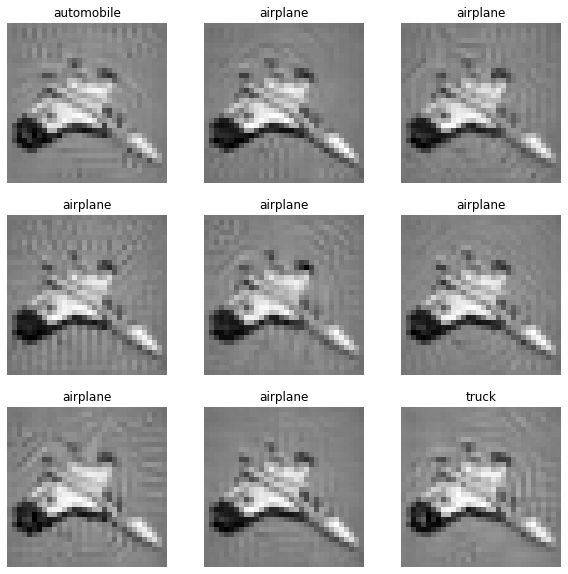

In [28]:
plt.figure(figsize=(10,10))
for i in range(len(generated_images)):
  plt.subplot(len(images)*3, (len(classes) - 1)/3, i+1)
  plt.axis('off')
  plt.imshow(((generated_images[i]+1)/2).reshape((32,32)), cmap='gray')
  plt.title(labels[np.argmax(deeper_discriminator.predict(generated_images[i]))])
# save plot to file
filename = 'generated_images.png' 
plt.savefig(filename)
plt.show()

As we can see from the above results, although the Deeper Discriminator is not perfect at classifying the adversarial images, it managed to discern many of them which the Discriminator could not, while both of them undergone the same training. In this point we have to inform the reader that the number of correct answers depends both on the adversarial images and the weights of our Deeper Discriminator. In this case we got a bit lucky not because we scored a seven out of nine but because the training phase was pretty good for this kind of image. For example if we run again the algorithm we probably won't have the same accuracy. In fact we have tried it some times and our worst accuracy was three out of nine. Our hunch is that as much closer the accuracy gets to the maximum one, on the CIFAR-10 test set, our results on the adversarial images also get better. However, as much as we train Dicsciminator (first model), the adversarial images become much more difficult for Deeper Discriminator to classify them correctly, achieving a lower accuracy than the one above. What one should keep in mind after this experiment is that with the introduction of gaussian noise one can have its neural network generalize better and as a result build a first defense against adversarial images.